# Bank Churn Prediction<br>Introduction to Neural Networks
#### Thomas Webb<br>February 9th, 2021

##### `Context:`
Businesses that provide a service, like banks, have to worry about the problem of **"Churn"** **(i.e. customers leaving and joining another service provider)**. It is important for the business to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

##### `Objective:`
**Build an artificial neural network-based classifier that, when given any bank customer's data history, can determine whether or not they will leave the bank in the next 6 months.**<br><br>
This case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc. A link to the Kaggle project site can be found here:https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

# To build neural network models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# To use sklearn optimization algorithms with keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# For confusion matrix visualization
from sklearn.metrics import confusion_matrix
import itertools

# Formatting
sns.set(rc={'figure.figsize':(15,10)})
%matplotlib inline
# warnings.filterwarnings('ignore')

#### Define Functions

In [2]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    """This function will generate a more useful and easy to understand
    confusion matrix using the output of sklearn.metrix.confusion_matrix"""
    
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black",
                fontsize=36)
    plt.xlabel("Predicted")
    plt.ylabel("True")

# Load and Examine the Data Set

In [3]:
df = pd.read_csv("bank.csv")

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### `Insights:`
- **RowNumber** and **CustomerId** are variables that carry no predictive value, as they are entry identifiers, and can be dropped. **Surname** may also have negligible predictive power.
- **Geography**, **Gender**, and **NumOfProducts** are categorical variables that should be one-hot encoded in order to increase their predictive value.

In [5]:
# A zero returned is indicative of no missing values
df.isnull().sum().sum()

0

In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


##### `Insights:`
- There are a large amount of entries with a **Balance** of **zero dollars**, which is possible, but seems unlikely. This will likely skew the data.
- There are some values for EstimatedSalary that appear much too low for an annual salary, like **11 dollars**. Perhaps the hourly wage rate was entered by mistake for these isntances? Will consider replacing or dropping those values.

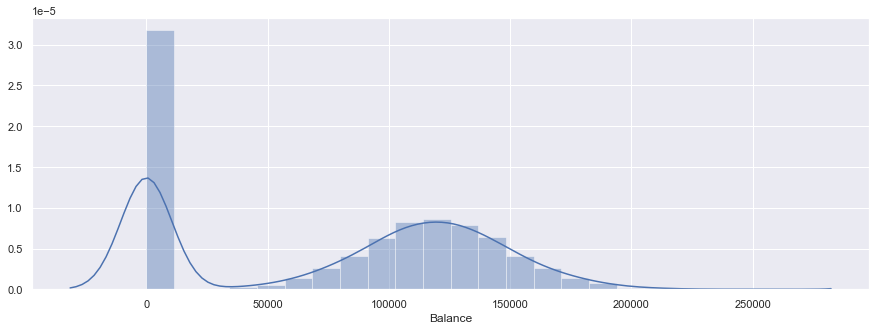

In [7]:
# Visualize the skewness of the "Balance" column 
# Created by 3,000+ accounts with $0 balance
plt.figure(figsize=(15, 5))
sns.distplot(df['Balance'], norm_hist=True)
plt.show()

##### `Insights:`
It appears that around 1/3 of the dataset has an account balance of $0. 

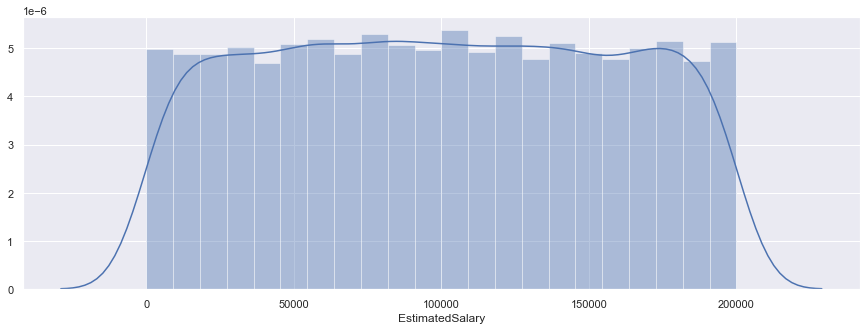

In [8]:
# Visualize the "EstimatedSalary" distribution to inspect abnormally low values
plt.figure(figsize=(15, 5))
sns.distplot(df['EstimatedSalary'], norm_hist=True)
plt.show()

In [9]:
# Drop "RowNumber", "CustomerId", and "Surname"
df = df.drop(['RowNumber'], axis = 1)
df = df.drop(['CustomerId'], axis = 1)
df = df.drop(['Surname'], axis = 1)

# Bivariate Data Analysis

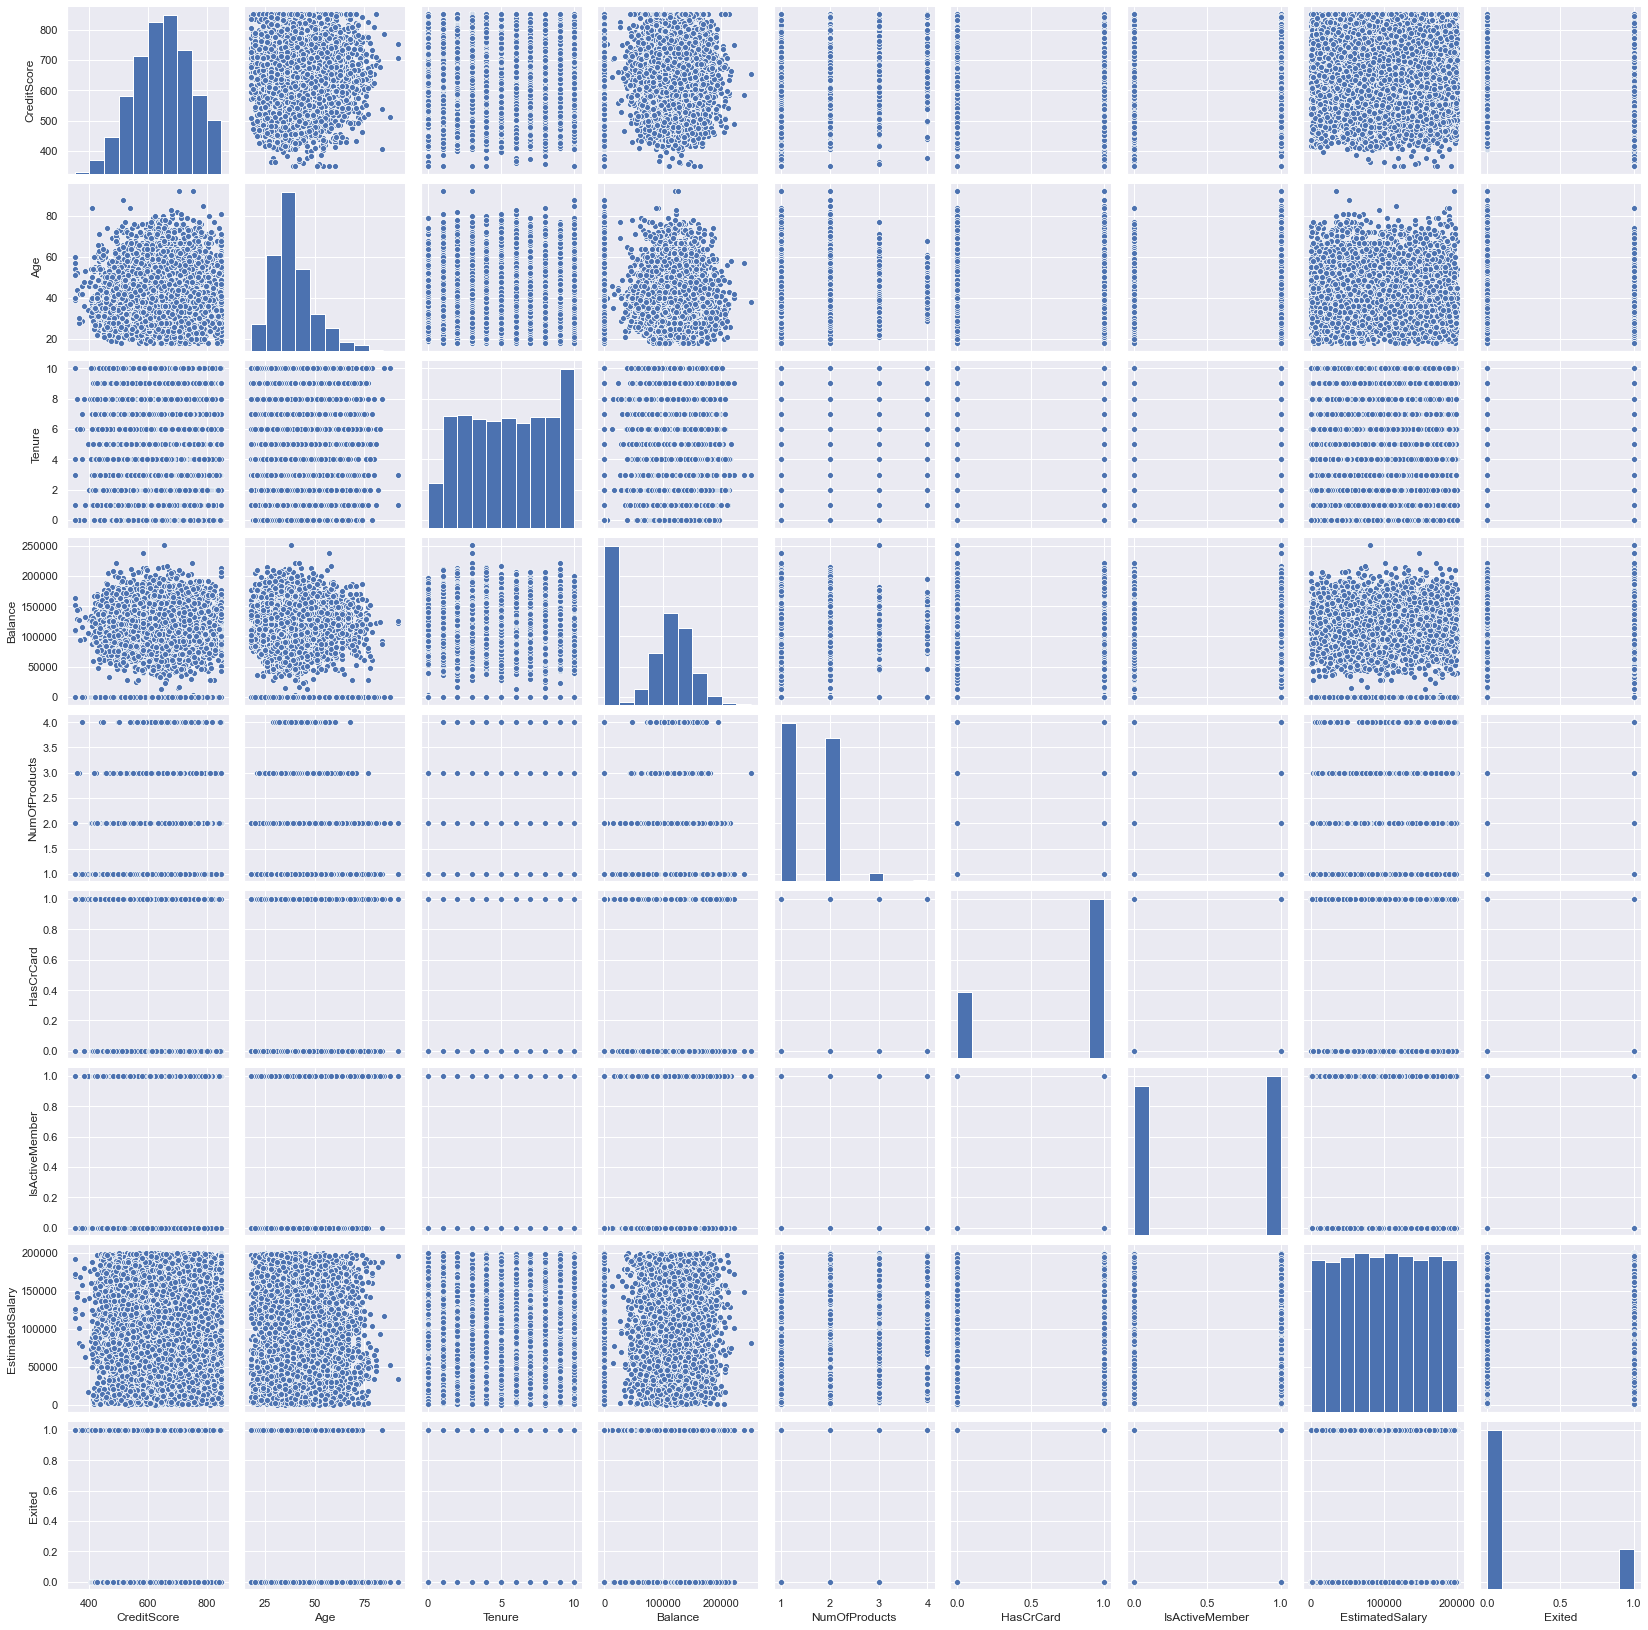

In [10]:
# Pairplot
sns.pairplot(df)

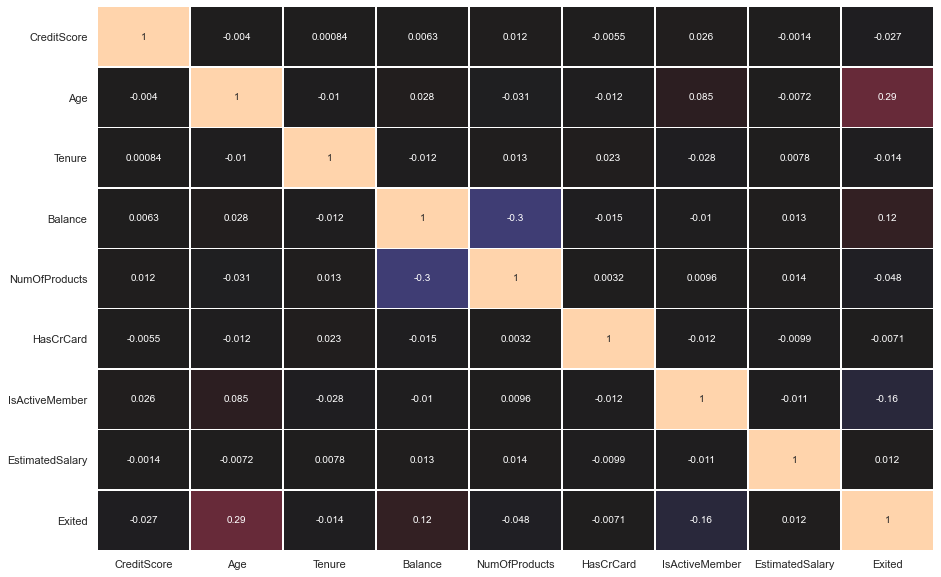

In [11]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False)
plt.show()

In [12]:
# Evaluate mean values for each outcome of the target variable
df.groupby(['Exited']).mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


In [13]:
# Evaluate median values for each outcome of the target variable
df.groupby(['Exited']).median()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,653,36,5,92072.68,2,1,1,99645.04
1,646,45,5,109349.29,1,1,0,102460.84


##### `Insights:`
- No individual column variable has a very significant correlation witht he target variable, however **Balance**, **Age**, and **IsActiveMember** appear to have more correlation than the rest of the columns.
- While there is evidence of minor skew, it is clear that customer who exit the bank (or "churn") generally have:
    - a higher **Balance** 
    - higher **Age** 
    - lower **NumOfProducts** 
    - are less likely to be **IsActiveMember**

# Preparing the Data Set

In [14]:
# One-hot encode "Geography", "Gender", and "NumOfProducts"
df = pd.get_dummies(df,columns=['Geography','Gender','NumOfProducts'])

In [15]:
x = df.iloc[:, np.r_[0:7,8:17]]
y = df.Exited

print(df.shape)
print(x.shape)
print(y.shape)

(10000, 17)
(10000, 16)
(10000,)


In [16]:
# Split the data into the Train and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
# Normalize the data
scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [18]:
x_train.shape

(7000, 16)

# Building the first Neural Network Model Iteration

In [85]:
# Initalize the Model
model = Sequential([Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')]) # binary output

##### `Note:`
- The number of dense layers and number of neurons per layer is a relatively structured sequence, but almost completely arbitrary. This will serve as a reference and a building block to train and tune the model.

In [86]:
model.compile(loss='binary_crossentropy', 
              optimizer = 'rmsprop', 
              metrics = ['accuracy'])

##### `Note:`
- Similarly to the number of neurons and number of layers, the optimizer is also arbitrary at this stage and can be modified and tuned later on.
- "binary_crossentropy" is the correct loss function for a binary classification model, and will not be changed.

In [87]:
history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.33, 
                    epochs=100, 
                    batch_size=10, 
                    verbose=0)

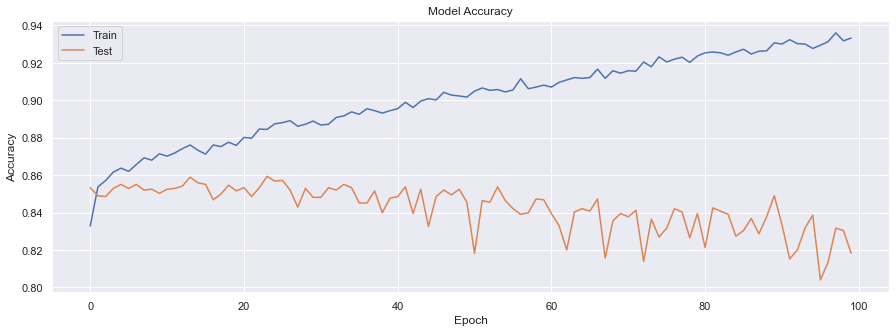

In [88]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### `Insights:`
- We can already see that we have created a predictive model that is not very strong. The increasing gap in accuracy between training data over testing data is clear evidence that we have **overfit** the model.
- In the next iterations, we can attempt to decrease overfitting by using **less hidden layers**, **less neurons in each hidden layer**, as well as **fewer epochs**.

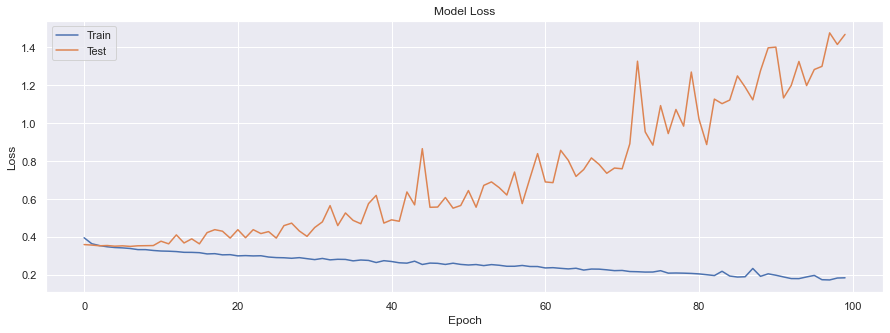

In [89]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### `Insights:`
- We can see a clear learning rate within the training data, but the testing data is actually **worsening** over time. This is again clear **evidence of overfitting** the model, as we should expect the testing data loss to be decrease at a similar rate as the training data.

# Predictions Analysis

[[2091  282]
 [ 309  318]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2373
           1       0.53      0.51      0.52       627

    accuracy                           0.80      3000
   macro avg       0.70      0.69      0.70      3000
weighted avg       0.80      0.80      0.80      3000



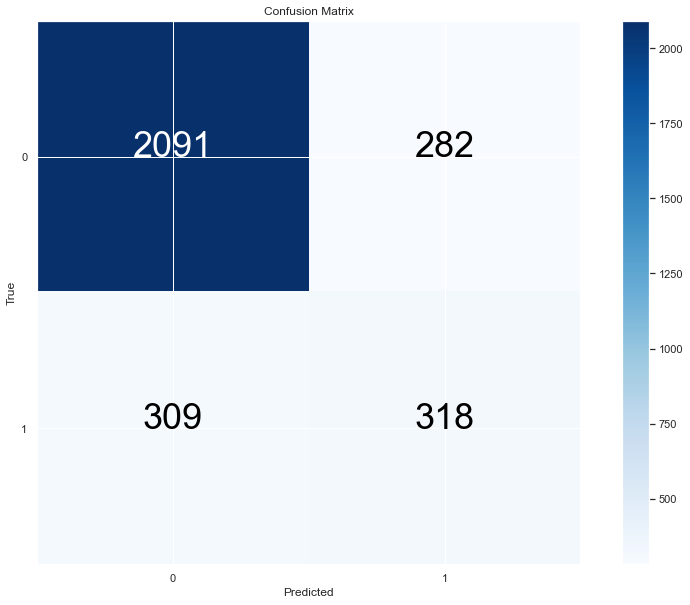

In [90]:
# Create the predictions array based on the x_test data
y_predict = pd.DataFrame(model.predict(x_test)>.5).astype("int32")

# Construct a confusion matrix to show the outcomes of the predictions
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
cm_plot_labels = ["0", "1"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Print a clsasification report with valuable statistics on prediction
cr = metrics.classification_report(y_test,y_predict)
print(cr)

In [91]:
# Store important values from the classification report into a DataFrame
results = pd.DataFrame({"Iteration":['First'], 
                        "Accuracy": cr[203:207],
                        "Macro Avg Recall": cr[247:251],
                        "Weighted Avg Recall": cr[301:305], 
                        "Macro Avg Precision": cr[237:241],
                        "Weighted Avg Precision": cr[291:295],
                        "Macro Avg F1-Score": cr[257:261],
                        "Weighted Avg F1-Score": cr[311:315]})

# Using an Optimization Algorithm (GridSearchCV) to Tune the Model's Hyper-Parameters

During some research, a few general guidelines were found for selecting successful parameters of a neural network model. Jeff Heaton, author of ***Introduction to Neural Networks in Java*** says, "*for most problems, one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules:*" 

- *(i) number of hidden layers equals one; and* 
- *(ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.*<br>

For this reason the **Hidden Layer (9)** has been set as the rounded mean of the **Input(16)** and **Output (1)** Layers.<br>

It is important to note that Heaton also says, "These three rules provide a starting point for you to consider. Ultimately, the selection of an architecture for your neural network will come down to trial and error." It is implied that the most optimal number of layers and neurons per layer is completely dependent on the size and complexity of the data. 


In [48]:
# This function will be called by the KerasClassifier in order to perform
# a gridsearch over a few of the hyper-parameters in our model.

def create_model(optimizer='adam'):
    
    """This function will be called by the KerasClassifier 
    in order to perform a gridsearch over a few of 
    the hyper-parameters in our model."""
    
    model = Sequential()
    model.add(Dense(16, activation='relu'))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [49]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
nn_model = KerasClassifier(build_fn=create_model, verbose=2)

In [50]:
from sklearn.pipeline import Pipeline
estimator = Pipeline([("ss", StandardScaler(with_mean=False)),("nn",nn_model)])

In [51]:
# Define lists of parameters and eligible values to use in GridSearchCV
param_grid = {'nn__epochs':[16,32,64],
              'nn__batch_size':[16,32,64,128],
              'nn__optimizer':['RMSprop','Adam']}

In [52]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=estimator,
                    n_jobs=-1,
                    verbose=0,
                    return_train_score=True,
                    param_grid=param_grid)

In [53]:
grid_result = grid.fit(x_train, y_train)

Epoch 1/32
438/438 - 1s - loss: 0.4255 - accuracy: 0.8154
Epoch 2/32
438/438 - 0s - loss: 0.3735 - accuracy: 0.8463
Epoch 3/32
438/438 - 0s - loss: 0.3623 - accuracy: 0.8500
Epoch 4/32
438/438 - 0s - loss: 0.3569 - accuracy: 0.8521
Epoch 5/32
438/438 - 0s - loss: 0.3536 - accuracy: 0.8550
Epoch 6/32
438/438 - 0s - loss: 0.3515 - accuracy: 0.8551
Epoch 7/32
438/438 - 0s - loss: 0.3486 - accuracy: 0.8570
Epoch 8/32
438/438 - 0s - loss: 0.3472 - accuracy: 0.8571
Epoch 9/32
438/438 - 0s - loss: 0.3455 - accuracy: 0.8577
Epoch 10/32
438/438 - 0s - loss: 0.3443 - accuracy: 0.8569
Epoch 11/32
438/438 - 0s - loss: 0.3430 - accuracy: 0.8591
Epoch 12/32
438/438 - 0s - loss: 0.3419 - accuracy: 0.8596
Epoch 13/32
438/438 - 0s - loss: 0.3401 - accuracy: 0.8594
Epoch 14/32
438/438 - 0s - loss: 0.3395 - accuracy: 0.8601
Epoch 15/32
438/438 - 0s - loss: 0.3377 - accuracy: 0.8607
Epoch 16/32
438/438 - 0s - loss: 0.3372 - accuracy: 0.8617
Epoch 17/32
438/438 - 0s - loss: 0.3367 - accuracy: 0.8624
Epoch 

In [54]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.856857 using {'nn__batch_size': 16, 'nn__epochs': 32, 'nn__optimizer': 'RMSprop'}


##### `Insights:`
According to our GridSearch, the optimal parameters to use (out of the ones provided), are:
- **batch_size**: 16
- **epochs**: 32
- **optimizer**: "RMSprop"<br>

Now, we can construct a model using the format from our gridsearch with those highlighted parameters and analyze the results.

# Building the Second Iteration

In [92]:
# Initalize the Model
model = Sequential([Dense(16, activation = 'relu'),
                    Dense(9, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')])

In [93]:
model.compile(loss='binary_crossentropy', 
              optimizer = 'RMSprop', 
              metrics = ['accuracy'])

In [94]:
history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.33, 
                    epochs=32, 
                    batch_size=16, 
                    verbose=0)

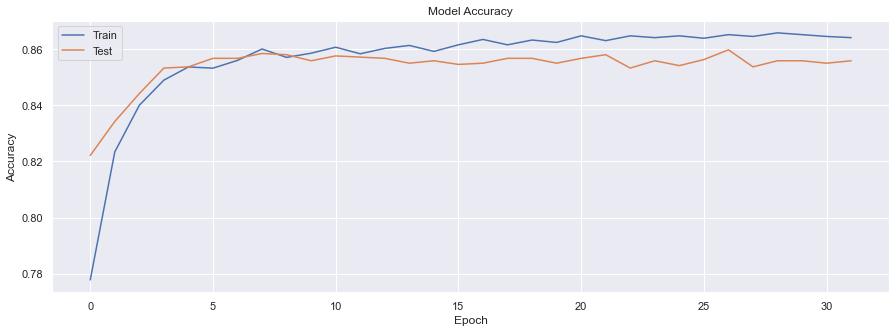

In [95]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### `Insights:`
- While this model does perform slightly better, we can still see evidence of **overfitting** in the separation of training and testing accuracies after some point around 20 epochs.

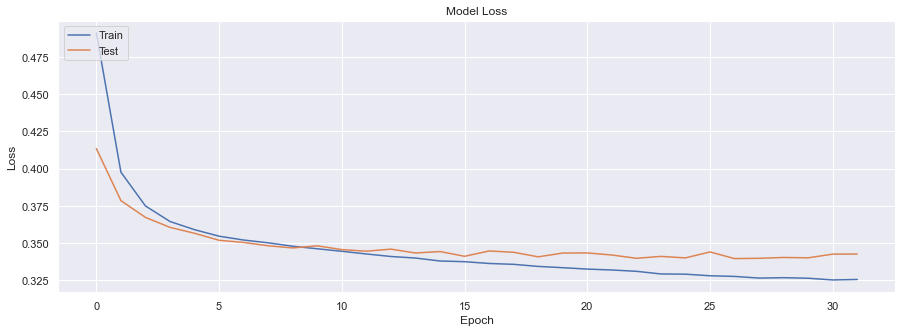

In [96]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### `Insights:`
- Here we notice a dramatic improvement in the fit of the model. Our loss function for the testing data has decreased alongside the loss of the training, and even though it has also **overfit** around 15 epochs, the contour is a great improvement from our first iteration.

[[2292   81]
 [ 329  298]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2373
           1       0.79      0.48      0.59       627

    accuracy                           0.86      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.86      0.85      3000



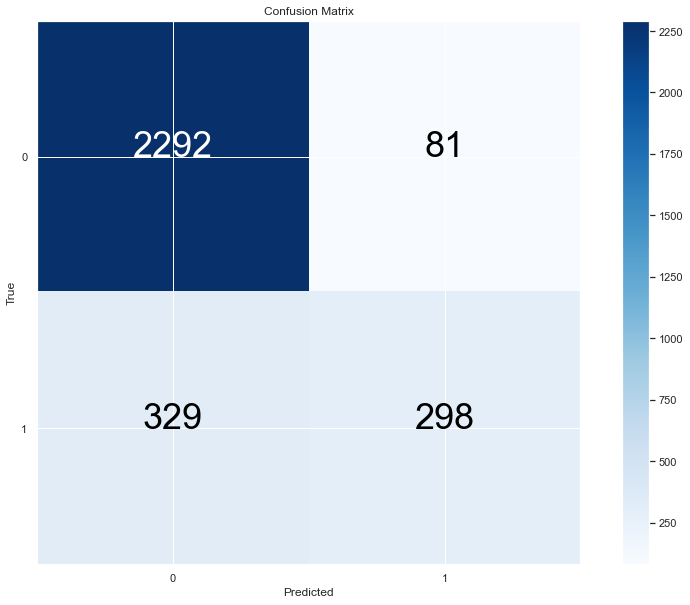

In [97]:
# Create the predictions array based on the x_test data
y_predict = pd.DataFrame(model.predict(x_test)>.5).astype("int32")

# Construct a confusion matrix to show the outcomes of the predictions
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
cm_plot_labels = ["0", "1"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Print a clsasification report with valuable statistics on prediction
cr = metrics.classification_report(y_test,y_predict)
print(cr)

##### `Insights:`
- Somer research and thoughfulness in selecting the number of layers and layer size, alongside **GridSearchCV** (hyper-parameter tuning algorithm) has gained our model an impressive nearly **6% increase in overall accuracy**.

In [98]:
# Store important values from the classification report into a DataFrame
tempResults = pd.DataFrame({"Iteration":['Second'], 
                        "Accuracy": cr[203:207],
                        "Macro Avg Recall": cr[247:251],
                        "Weighted Avg Recall": cr[301:305], 
                        "Macro Avg Precision": cr[237:241],
                        "Weighted Avg Precision": cr[291:295],
                        "Macro Avg F1-Score": cr[257:261],
                        "Weighted Avg F1-Score": cr[311:315]})

# Combine results DataFrames in order to compare metrics
results = pd.concat([results, tempResults])

# Final Iteration

The final iteration will be a trail and error attempt to correct some miscues from the previous iterations, by analyzing the accuracy and loss graphs, we can attempt to maximize accuracy while we prevent overfitting.

In [99]:
# Initalize the Model
model = Sequential([Dense(32, activation = 'relu'),
                    Dense(16, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')])

In [100]:
model.compile(loss='binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [101]:
history = model.fit(x_train, 
                    y_train, 
                    validation_split=0.33, 
                    epochs=20, 
                    batch_size=100, 
                    verbose=0)

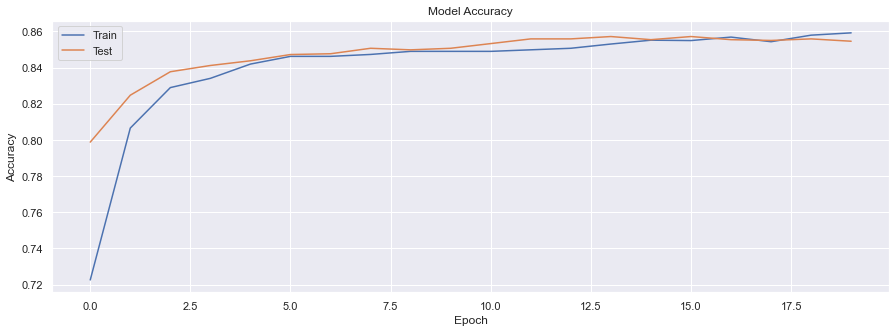

In [102]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### `Insights:`
- Our overall accuracy has not improved by much, however, this graph shows we have a more stable predictive model by the fact that there is no longer evidence of overfitting.

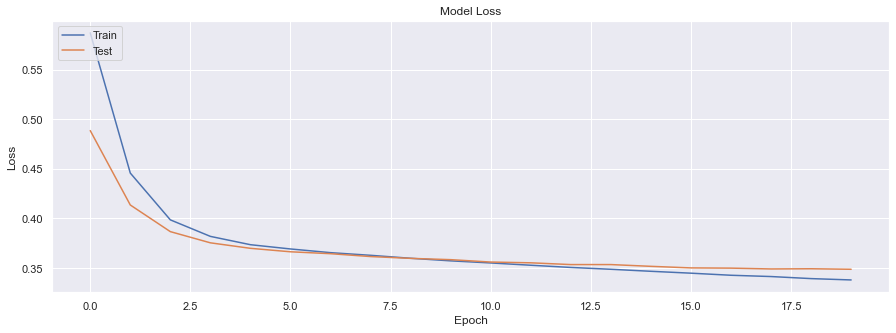

In [103]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### `Insights:`
- Similarly to accuracy, we have minimized overfitting, while maintaining an efficient learning rate.

[[2282   91]
 [ 325  302]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2373
           1       0.77      0.48      0.59       627

    accuracy                           0.86      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



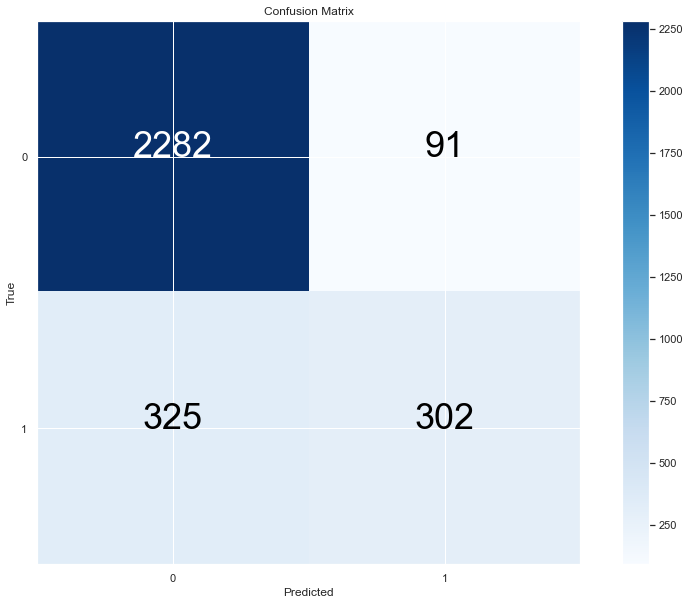

In [104]:
# Create the predictions array based on the x_test data
y_predict = pd.DataFrame(model.predict(x_test)>.5).astype("int32")

# Construct a confusion matrix to show the outcomes of the predictions
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
cm_plot_labels = ["0", "1"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Print a clsasification report with valuable statistics on prediction
cr = metrics.classification_report(y_test,y_predict)
print(cr)

In [105]:
# Store important values from the classification report into a DataFrame
tempResults = pd.DataFrame({"Iteration":['Third'], 
                        "Accuracy": cr[203:207],
                        "Macro Avg Recall": cr[247:251],
                        "Weighted Avg Recall": cr[301:305], 
                        "Macro Avg Precision": cr[237:241],
                        "Weighted Avg Precision": cr[291:295],
                        "Macro Avg F1-Score": cr[257:261],
                        "Weighted Avg F1-Score": cr[311:315]})

# Combine results DataFrames in order to compare metrics
results = pd.concat([results, tempResults])

# Conclusion

Let's review our comprehensive results dataframe.

In [106]:
results.set_index('Iteration').T

Iteration,First,Second,Third
Accuracy,0.80,0.86,0.86
Macro Avg Recall,0.69,0.72,0.72
Weighted Avg Recall,0.80,0.86,0.86
Macro Avg Precision,0.70,0.83,0.82
Weighted Avg Precision,0.80,0.86,0.85
Macro Avg F1-Score,0.70,0.76,0.75
Weighted Avg F1-Score,0.80,0.85,0.85


##### `Insights:`
- While accuracy is important, and we can see a general improvement in **accuracy** over our iterations, **recall** and **precision** are also important, especially considering the distribution of our target variable. Almost all of the metrics of our models have also increased over the course of our iterations, which means the model was tuned successfully.